In [1]:
import inox
import inox.nn as nn
import jax
import jax.numpy as jnp
import optax

from inox.random import PRNG
from tqdm import trange
from typing import *

from utils import *

In [2]:
rng = PRNG(0)

## Data

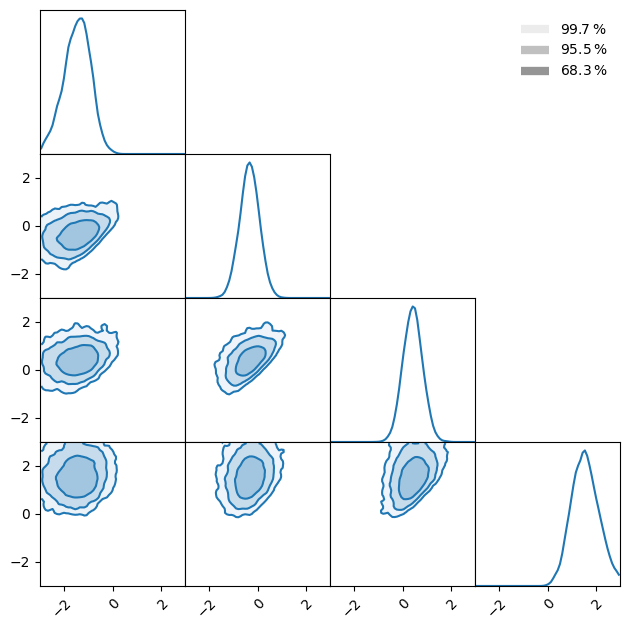

In [3]:
n = 8192
x = generate(n, key=rng.split())
fig = show(x)

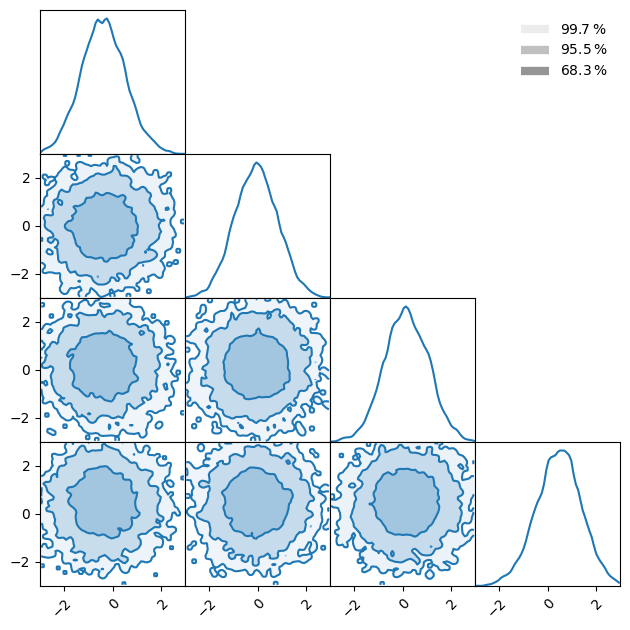

In [4]:
def measure(A, x):
    return jnp.einsum('...ij,...j->...i', A, x)

A = rng.normal((n, 3, 10)) / 10 ** 0.5
y = measure(A, x) + 1e-3 * rng.normal((n, 3))

def sample(model, A, y):
    sampler = Euler(
        PosteriorScoreModel(
            model=model,
            A=inox.Partial(measure, A),
            y=y,
            noise=1e-3,
            gamma=1.0,
        ),
    )

    z = rng.normal((n, 10))

    return sampler(z, steps=64)

x_bis = sample(StandardScoreModel(), A, y)
fig = show(x_bis)

## Training

In [5]:
def train(x, A, y):
    model = make_model(key=rng.split())
    static, params, others = model.partition(nn.Parameter)

    scheduler = optax.linear_schedule(init_value=1e-3, end_value=1e-6, transition_steps=16384)
    optimizer = optax.adam(learning_rate=scheduler)
    opt_state = optimizer.init(params)

    objective = EDMLoss()

    @jax.jit
    def sgd_step(params, others, opt_state, x, A, key):
        keys = jax.random.split(key, 2)

        z = jax.random.normal(keys[0], shape=x.shape)
        t = jax.random.uniform(keys[1], shape=x.shape[:1])

        def ell(params):
            return objective(static(params, others), x, z, t, inox.Partial(measure, A))

        loss, grads = jax.value_and_grad(ell)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)

        return loss, params, opt_state

    for step in (bar := trange(16384)):
        i = rng.randint(shape=(256,), minval=0, maxval=len(y))

        loss, params, opt_state = sgd_step(params, others, opt_state, x[i], A[i], rng.split())

        bar.set_postfix(loss=float(loss))

    return static(params, others)

100%|██████████| 16384/16384 [01:27<00:00, 187.07it/s, loss=0.572]


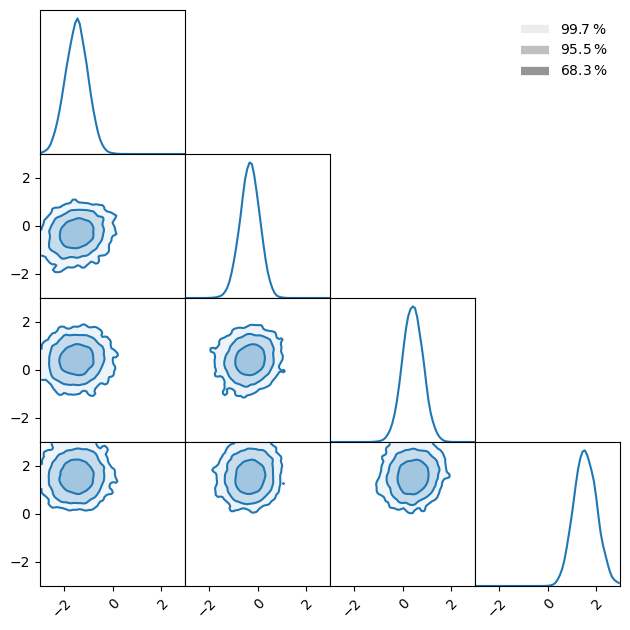

In [6]:
model = train(x_bis, A, y)
x_bis = sample(model, A, y)
fig = show(x_bis)

100%|██████████| 16384/16384 [01:26<00:00, 188.68it/s, loss=0.573]


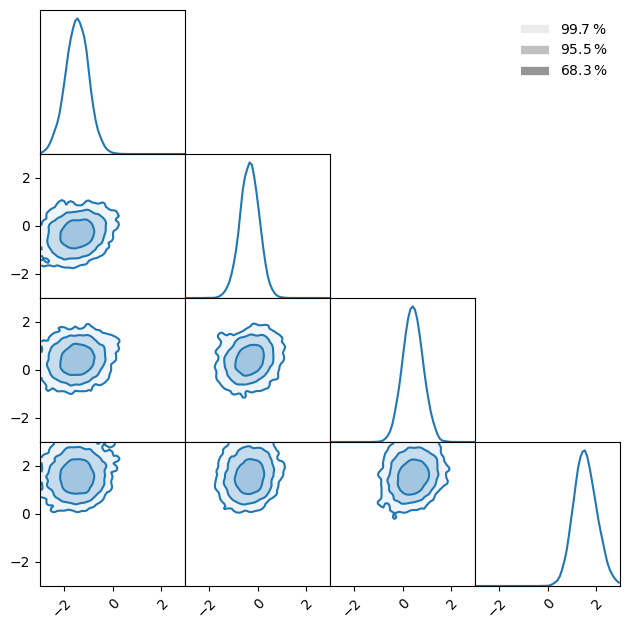

In [7]:
model = train(x_bis, A, y)
x_bis = sample(model, A, y)
fig = show(x_bis)

100%|██████████| 16384/16384 [01:24<00:00, 194.49it/s, loss=0.648]


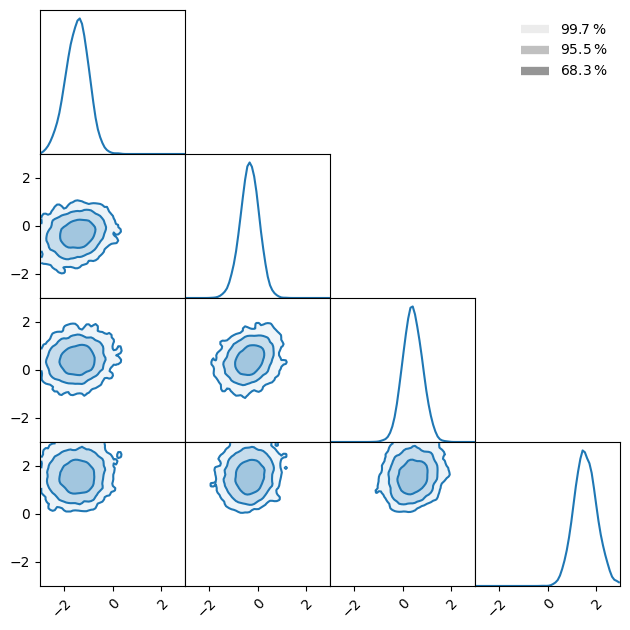

In [8]:
model = train(x_bis, A, y)
x_bis = sample(model, A, y)
fig = show(x_bis)

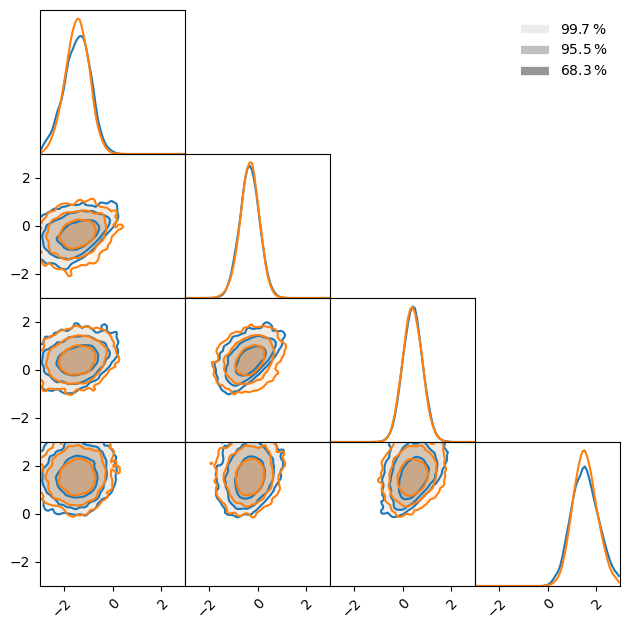

In [9]:
sampler = Euler(model)
x_ter = sampler(rng.normal((n, 10)), steps=64)

fig = show(x)
fig = show(x_ter, figure=fig)